<img src="OC.png" width="50" height="50" align="left">    

***

<center> <font size="6"> <span style='color:Blue'> P7: Implémentez un modèle de scoring </span></font> </center>  

***

<font size="3"> <span style="font-size: 1.5em" > **Partie 2 - 2/2: Modélisation** </span> </font> 

**Contexte**  
**Prêt à dépenser** est une société financière qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.
<img src="pretadepenser.png" width="200" height="200">
**Mission**   
* Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
* Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
* Mettre en production le modèle de scoring de prédiction à l’aide d’une API, ainsi que le dashboard interactif qui appelle l’API pour les prédictions.

Dans ce notebook, nous allons:
* Rappeler le modèle choisi et ses performances.
* Sauvegarder le modèle. 

# Importation des données et des librairies Python pour DS

In [15]:
# ------------------------------------------
# Projet : Implémenter un modèle de scoring
# Données: https://www.kaggle.com/c/home-credit-default-risk/data
# Auteur : Rim BAHROUN
# Date: Avril 2023
# OpenClassrooms
# -------------------------------------------
# importation des librairies Python pour DS
# -------------------------------------------
import os
import csv
import numpy as np
import pandas as pd
import timeit

from sklearn.model_selection import train_test_split
from sklearn import pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer, f1_score, fbeta_score, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import pickle

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [3]:
train_df = pd.read_csv("data/traited/df_credit_train_35.csv")
print(train_df.shape)
train_df.head(2)

(307507, 35)


,SK_ID_CURR,TARGET,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_MONTHS_BALANCE_SIZE_MEAN,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_TYPE_Creditcard_MEAN,BURO_STATUS_0_MEAN_MEAN,ACTIVE_DAYS_CREDIT_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,CLOSED_DAYS_CREDIT_MAX,CLOSED_DAYS_CREDIT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_NAME_PRODUCT_TYPE_XNA_MEAN,PREV_NAME_SELLER_INDUSTRY_Consumerelectronics_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,REFUSED_DAYS_DECISION_MAX,POS_MONTHS_BALANCE_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM
0,100002,1.0,0.018801,-9461,-3648.0,-2120,10,0.083037,0.262949,0.139376,-1134.0,-1437.0,-103.0,-874.00,13.75,0.25,0.5,0.406960,-1042.0,-103.0,-572.5,-476.0,-974.500000,-606.0,-606.0,1.0,0.000000,1.0,1.000000,0.000000,0.0,1.000000,-396.0,-10.000000,3960000.0
1,100003,0.0,0.003541,-16765,-1186.0,-291,11,0.311267,0.622246,0.535276,-828.0,-2586.0,-606.0,-1400.75,24.75,0.25,0.5,0.436423,-606.0,-606.0,-606.0,-775.0,-1665.666667,-2341.0,-1305.0,1.0,0.666667,0.0,0.666667,0.333333,0.0,0.333333,-396.0,-43.785714,3960000.0


In [4]:
test_df = pd.read_csv("data/traited/df_credit_test_35.csv")
print(test_df.shape)
test_df.head(2)

(48744, 35)


,SK_ID_CURR,TARGET,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_MONTHS_BALANCE_SIZE_MEAN,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_TYPE_Creditcard_MEAN,BURO_STATUS_0_MEAN_MEAN,ACTIVE_DAYS_CREDIT_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,CLOSED_DAYS_CREDIT_MAX,CLOSED_DAYS_CREDIT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_NAME_PRODUCT_TYPE_XNA_MEAN,PREV_NAME_SELLER_INDUSTRY_Consumerelectronics_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,REFUSED_DAYS_DECISION_MAX,POS_MONTHS_BALANCE_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM
0,100001,NaN,0.018850,-19241,-5170.0,-812,18,0.752614,0.789654,0.159520,-1740.0,-1572.0,-49.0,-735.000000,24.571429,0.428571,0.000000,0.336651,-559.0,-49.0,-309.333333,-857.0,-1054.25,-1740.0,-1740.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,-396.0,-72.555556,3960000.0
1,100005,NaN,0.035792,-18064,-9118.0,-1623,9,0.564990,0.291656,0.432962,0.0,-373.0,-62.0,-190.666667,7.000000,0.666667,0.333333,0.735043,-137.0,-62.0,-99.500000,-373.0,-373.00,-757.0,-536.0,0.5,0.5,1.0,1.0,0.0,0.5,0.0,-396.0,-20.000000,3960000.0


In [5]:
x = train_df.drop(columns=["SK_ID_CURR", 'TARGET'])
y = train_df.loc[:, train_df.columns=='TARGET']

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x, y, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [7]:
x_val

,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_MONTHS_BALANCE_SIZE_MEAN,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_TYPE_Creditcard_MEAN,BURO_STATUS_0_MEAN_MEAN,ACTIVE_DAYS_CREDIT_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,CLOSED_DAYS_CREDIT_MAX,CLOSED_DAYS_CREDIT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_NAME_PRODUCT_TYPE_XNA_MEAN,PREV_NAME_SELLER_INDUSTRY_Consumerelectronics_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,REFUSED_DAYS_DECISION_MAX,POS_MONTHS_BALANCE_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM
232923,0.025164,-9267,-372.0,-785,15,0.044202,0.544933,0.535276,-1440.0,-1827.0,-300.0,-1050.571429,24.750000,0.375000,0.200000,0.436423,-764.0,-258.0,-537.309524,-729.0,-1366.555556,-2344.0,-850.200000,0.500000,0.300000,0.400000,0.800000,0.200000,0.300000,0.000000,-272.0,-43.150000,3960000.0
263698,0.015221,-10916,-532.0,-3534,13,0.543037,0.587365,0.692559,-3.0,-2891.0,-293.0,-1397.461538,24.750000,0.384615,0.230769,0.436423,-722.0,-293.0,-539.000000,-1147.0,-1934.000000,-1502.0,-789.000000,0.800000,0.700000,0.500000,0.750000,0.200000,0.142857,0.111111,-396.0,-28.593750,3960000.0
36463,0.046220,-10066,-4059.0,-2511,14,0.505998,0.643635,0.535276,-1059.0,-1827.0,-300.0,-1050.571429,24.750000,0.375000,0.200000,0.436423,-764.0,-258.0,-537.309524,-729.0,-1366.555556,-1059.0,-657.000000,0.500000,0.500000,1.000000,1.000000,0.000000,0.500000,0.000000,-396.0,-29.000000,3960000.0
279380,0.046220,-18698,-8905.0,-2242,18,0.505998,0.746168,0.360613,-3638.0,-1877.0,-235.0,-1127.428571,32.285714,0.428571,0.142857,0.666539,-1209.0,-235.0,-731.666667,-892.0,-1424.250000,-976.0,-807.500000,0.500000,1.000000,0.500000,0.000000,0.000000,0.000000,0.000000,-639.0,-16.500000,3960000.0
148324,0.018801,-18162,-7108.0,-1522,7,0.505998,0.648460,0.486653,-1827.0,-2434.0,-201.0,-1086.166667,24.750000,0.333333,0.166667,0.436423,-695.0,-695.0,-695.000000,-201.0,-1281.750000,-1827.0,-1156.333333,0.666667,0.333333,0.666667,0.333333,0.000000,0.000000,0.000000,-773.0,-54.000000,3960000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34300,0.006008,-8768,-8765.0,-1410,9,0.460036,0.696205,0.321735,-1061.0,-1345.0,-163.0,-607.500000,7.750000,0.500000,0.500000,0.630411,-308.0,-163.0,-235.500000,-614.0,-979.500000,-1061.0,-567.800000,0.600000,0.600000,0.400000,0.800000,0.400000,0.400000,0.200000,-396.0,-18.954545,3960000.0
304790,0.007274,-22431,-4526.0,-4526,9,0.753637,0.404618,0.531686,0.0,-1436.0,-753.0,-1094.500000,36.500000,0.500000,0.500000,0.121667,-753.0,-753.0,-753.000000,-1436.0,-1436.000000,-1502.0,-789.000000,0.800000,0.700000,0.500000,0.750000,0.200000,0.142857,0.111111,-396.0,-28.593750,3960000.0
110630,0.002042,-14798,-1497.0,-4211,13,0.505998,0.489780,0.535276,-1115.0,-1827.0,-300.0,-1050.571429,24.750000,0.375000,0.200000,0.436423,-764.0,-258.0,-537.309524,-729.0,-1366.555556,-1115.0,-397.400000,0.600000,0.400000,0.400000,0.600000,0.000000,0.000000,0.200000,-396.0,-21.550000,585000.0
290716,0.018029,-17253,-5321.0,-762,12,0.682599,0.431879,0.165407,-1638.0,-2906.0,-144.0,-1628.500000,5.900000,0.300000,0.200000,0.850000,-1715.0,-144.0,-1156.333333,-1046.0,-1830.857143,-1884.0,-855.166667,0.666667,0.500000,0.333333,0.666667,0.333333,0.166667,0.166667,-396.0,-34.826923,7200000.0


In [32]:
val_df = train_df.loc[train_df.index.isin(x_val.index), :]
print(val_df.shape)

(101478, 35)


In [33]:
val_df

,SK_ID_CURR,TARGET,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_MONTHS_BALANCE_SIZE_MEAN,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_TYPE_Creditcard_MEAN,BURO_STATUS_0_MEAN_MEAN,ACTIVE_DAYS_CREDIT_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,CLOSED_DAYS_CREDIT_MAX,CLOSED_DAYS_CREDIT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_NAME_PRODUCT_TYPE_XNA_MEAN,PREV_NAME_SELLER_INDUSTRY_Consumerelectronics_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,REFUSED_DAYS_DECISION_MAX,POS_MONTHS_BALANCE_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM
0,100002,1.0,0.018801,-9461,-3648.0,-2120,10,0.083037,0.262949,0.139376,-1134.0,-1437.0,-103.0,-874.000000,13.750000,0.250000,0.500000,0.406960,-1042.0,-103.0,-572.500000,-476.0,-974.500000,-606.0,-606.000000,1.0,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,-396.0,-10.000000,3960000.0
2,100004,0.0,0.010032,-19046,-4260.0,-2531,9,0.505998,0.555912,0.729567,-815.0,-1326.0,-408.0,-867.000000,24.750000,0.000000,0.000000,0.436423,-764.0,-258.0,-537.309524,-408.0,-867.000000,-815.0,-815.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-396.0,-25.500000,3960000.0
4,100007,0.0,0.028663,-19932,-4311.0,-3458,11,0.505998,0.322738,0.535276,-1106.0,-1149.0,-1149.0,-1149.000000,24.750000,0.000000,0.000000,0.436423,-764.0,-258.0,-537.309524,-1149.0,-1149.000000,-2357.0,-1222.833333,1.0,0.833333,0.333333,0.333333,0.500000,0.500000,0.000000,-396.0,-33.636364,3960000.0
6,100009,0.0,0.035792,-13778,-1213.0,-619,16,0.774761,0.724000,0.492060,-1562.0,-2882.0,-239.0,-1271.500000,24.750000,0.222222,0.111111,0.436423,-1293.0,-239.0,-591.750000,-684.0,-1465.714286,-1562.0,-719.285714,1.0,1.000000,0.285714,1.000000,0.857143,0.285714,0.142857,-396.0,-33.062500,3960000.0
10,100014,0.0,0.022800,-10197,-4427.0,-738,15,0.319760,0.651862,0.363945,-844.0,-2308.0,-376.0,-1095.375000,24.750000,0.250000,0.000000,0.436423,-423.0,-376.0,-399.500000,-435.0,-1327.333333,-844.0,-473.000000,1.0,0.500000,0.500000,1.000000,1.000000,0.000000,0.000000,-396.0,-18.250000,3960000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307491,456239,0.0,0.025164,-20922,-9596.0,-4440,14,0.505998,0.267834,0.597192,-2919.0,-2835.0,-195.0,-1529.909091,24.750000,0.454545,0.272727,0.436423,-1876.0,-195.0,-984.400000,-709.0,-1984.500000,-2919.0,-2822.500000,1.0,0.500000,0.500000,0.500000,0.000000,0.000000,0.500000,-396.0,-91.000000,14580000.0
307494,456242,0.0,0.072508,-19102,-746.0,-2650,10,0.505998,0.746259,0.406617,-734.0,-491.0,-491.0,-491.000000,17.000000,1.000000,1.000000,1.000000,-491.0,-491.0,-491.000000,-729.0,-1366.555556,-734.0,-447.000000,1.0,0.250000,0.250000,0.750000,0.750000,0.000000,0.250000,-396.0,-13.250000,1620000.0
307499,456247,0.0,0.022800,-11870,-675.0,-3936,11,0.243466,0.501221,0.609276,-2315.0,-2482.0,-287.0,-1043.181818,29.090909,0.272727,0.090909,0.325528,-712.0,-309.0,-453.666667,-287.0,-1264.250000,-2873.0,-1387.800000,0.8,1.000000,0.600000,1.000000,0.200000,0.200000,0.600000,-650.0,-57.333333,13680000.0
307503,456252,0.0,0.025164,-20775,-4388.0,-4090,8,0.505998,0.115992,0.535276,0.0,-1827.0,-300.0,-1050.571429,24.750000,0.375000,0.200000,0.436423,-764.0,-258.0,-537.309524,-729.0,-1366.555556,-2497.0,-2497.000000,1.0,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,-396.0,-79.000000,3960000.0


In [34]:
# val_df.to_csv("data/traited/df_credit_val_35.csv", index=False)

In [8]:
x_test = test_df.drop(columns=["SK_ID_CURR", 'TARGET'])

# Fonctions utiles

In [9]:
def Custom_score(y_true, y_pred):
    # coût d'un faux positif et un faux négatif
    cout_fp = 1
    cout_fn = 10
    
    # nombre total d'exemples positifs et négatifs
    n_pos = (y_true==1).sum()
    n_neg = (y_true==0).sum()
    # calcul du coût maximum possible
    max_cout = cout_fp * n_neg + cout_fn * n_pos
    
    # Calcul du nombre de faux positifs et faux négatifs
    fp = ((y_pred == 1) & (y_true == 0)).sum()
    fn = ((y_pred == 0) & (y_true == 1)).sum()
    
    # calcul du coût total    
    cout = (cout_fp * fp + cout_fn * fn)  # / (fn + fp)
    cout_notmalise = cout/max_cout
    score = round(1 - cout_notmalise, 2)
    return score[0]

custom_score = make_scorer(Custom_score, greater_is_better=True)

In [10]:
def model_eval_score(model, Xval, yval):
    
    yval_pred = model.predict(Xval)
    
    metrics = {'AUROC_score': round(roc_auc_score(yval, model.predict_proba(Xval)[:, 1]), 2),
               'Costum_score': round(Custom_score(yval, yval_pred.reshape(-1, 1)), 2),
               'f_beta_score': round(fbeta_score(yval, yval_pred, beta=3.16), 2),
               'Accuracy_score': round(accuracy_score(yval, yval_pred), 2),
               'Recall_score': round(recall_score(yval, yval_pred), 2),
               'Presicion_score': round(precision_score(yval, yval_pred), 2)}

    for key, val in metrics.items():
        print(key + ' : ' + str(val))
    print('conf_mat : \n' + str(confusion_matrix(yval, yval_pred)))
    print() 
    return metrics

# Pipeline 

## LogisticRegression

### Enregistrement du modèle 

In [10]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")

In [13]:
mlflow.sklearn.autolog(disable=True)

with mlflow.start_run(run_name='LogisticRegression'):
    params = {
        "solver": 'lbfgs',
        "class_weight" : 'balanced'
    }
    
    mlflow.set_tag("model_name", "LR_final")
    mlflow.log_params(params)
    
    pipeline_lr = pipeline.Pipeline([ ('scaler', StandardScaler()),
                             ('clf', LogisticRegression(**params))])

    pipeline_lr.fit(x_train, y_train)
    
    mlflow.log_metrics(model_eval_score(pipeline_lr, x_val, y_val))
    mlflow.sklearn.log_model(pipeline_lr, "sk_models") 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUROC_score : 0.73
Costum_score : 0.67
f_beta_score : 0.5
Accuracy_score : 0.68
Recall_score : 0.65
Presicion_score : 0.15
conf_mat : 
[[63851 29457]
 [ 2853  5317]]



C:\ProgramData\Anaconda3\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### Téléchargement du modèle et prédiction

In [11]:
model_name = "LR_final"
stage = "Production" # "Staging"  

model = mlflow.sklearn.load_model(model_uri=f"models:/{model_name}/{stage}")

model.predict(x_val)

array([1., 0., 0., ..., 0., 1., 0.])

In [12]:
df_ = test_df.loc[:, ["SK_ID_CURR", 'TARGET']]
df_.loc[:, 'TARGET'] = model.predict_proba(x_test)[:, 1]
df_.head()

,SK_ID_CURR,TARGET
0,100001,0.443131
1,100005,0.674566
2,100013,0.229805
3,100028,0.340662
4,100038,0.717714


Le AUROC score sur le jeu de test est de **0.72** sur Kaggle.

In [ ]:
#df_.to_csv('submission_lr.csv', index=False)

In [30]:
signature = infer_signature(x_train, y_train)

C:\Users\rimla\AppData\Roaming\Python\Python39\site-packages\mlflow\models\signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


In [31]:
#mlflow.sklearn.save_model(model, "LR_model", signature=signature)

In [ ]:
# mlflow models serve -m LR_model/

In [16]:
# save the model in the native sklearn format
filename = "lr_model.pkl"
pickle.dump(model, open(filename, "wb"))

In [17]:
# load the model into memory
loaded_model = pickle.load(open(filename, "rb"))

In [19]:
loaded_model.predict_proba(x_val)

array([[0.37860655, 0.62139345],
       [0.70772362, 0.29227638],
       [0.5967919 , 0.4032081 ],
       ...,
       [0.56057439, 0.43942561],
       [0.38358543, 0.61641457],
       [0.58966831, 0.41033169]])

## LGBMClassifier

### Enregistrement du modèle 

In [23]:
mlflow.sklearn.autolog(disable=True)

with mlflow.start_run(run_name='LGBMClassifier'):
    params = {
        "n_estimators": 500,
        "max_depth": 8, 
        "learning_rate": 0.02,
        "class_weight": 'balanced'
    }
    
    mlflow.set_tag("model_name", "LGBM_final")
    mlflow.log_params(params)
    
    pipeline_lgbm = pipeline.Pipeline([ ('scaler', StandardScaler()),
                             ('clf', LGBMClassifier(**params))])

    pipeline_lgbm.fit(x_train, y_train)
    
    mlflow.log_metrics(model_eval_score(pipeline_lgbm, x_val, y_val))
    mlflow.sklearn.log_model(pipeline_lgbm, "sk_models") 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUROC_score : 0.74
Costum_score : 0.68
f_beta_score : 0.51
Accuracy_score : 0.7
Recall_score : 0.65
Presicion_score : 0.16
conf_mat : 
[[65414 27894]
 [ 2820  5350]]



### Téléchargement du modèle et prédiction

In [20]:
model_name = "LGBM_final"
stage = "Staging"  # "Production"

model = mlflow.sklearn.load_model(model_uri=f"models:/{model_name}/{stage}")

model.predict(x_val)

array([1., 0., 1., ..., 1., 1., 1.])

In [16]:
df_ = test_df.loc[:, ["SK_ID_CURR", 'TARGET']]
df_.loc[:, 'TARGET'] = model.predict_proba(x_test)[:, 1]
df_.head()

,SK_ID_CURR,TARGET
0,100001,0.236890
1,100005,0.574510
2,100013,0.190605
3,100028,0.340771
4,100038,0.734250


Le AUROC score sur le jeu de test est de **0.73** sur Kaggle.

In [90]:
#df_.to_csv('submission_lgbm.csv', index=False)

In [33]:
#mlflow.sklearn.save_model(model, "LGBM_model", signature=signature)

In [36]:
np.array(x_val.iloc[0, :])

array([ 3.00000e-02, -9.26700e+03, -3.72000e+02, -7.85000e+02,
        1.50000e+01,  4.00000e-02,  5.40000e-01,  5.40000e-01,
       -1.44000e+03, -1.82700e+03, -3.00000e+02, -1.05057e+03,
        2.47500e+01,  3.80000e-01,  2.00000e-01,  4.40000e-01,
       -7.64000e+02, -2.58000e+02, -5.37310e+02, -7.29000e+02,
       -1.36656e+03, -2.34400e+03, -8.50200e+02,  5.00000e-01,
        3.00000e-01,  4.00000e-01,  8.00000e-01,  2.00000e-01,
        3.00000e-01,  0.00000e+00, -2.72000e+02, -4.31500e+01,
        3.96000e+06])

In [ ]:
# dans un terminal 
# mlflow models serve -m LR_model/
# curl http://127.0.0.1:5000/invocations -H 'Content-Type: application/json' -d '{"data": [[1, 2, 3, 4, 5, 6, 7, 8]]}'

In [21]:
# save the model in the native sklearn format
filename = "lgbm_model.pkl"
pickle.dump(model, open(filename, "wb"))

In [22]:
# load the model into memory
loaded_model = pickle.load(open(filename, "rb"))

In [23]:
loaded_model.predict_proba(x_val)

array([[0.26728926, 0.73271074],
       [0.78732277, 0.21267723],
       [0.49082392, 0.50917608],
       ...,
       [0.48061911, 0.51938089],
       [0.40371354, 0.59628646],
       [0.46737877, 0.53262123]])

# Préparation au dashboard

## Préparer un jeu de données équilibré de 20 individus pour le dashboard

In [137]:
df = pd.read_csv("data/traited/df_credit_val_35.csv")
df.head()

,SK_ID_CURR,TARGET,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_MONTHS_BALANCE_SIZE_MEAN,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_TYPE_Creditcard_MEAN,BURO_STATUS_0_MEAN_MEAN,ACTIVE_DAYS_CREDIT_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,CLOSED_DAYS_CREDIT_MAX,CLOSED_DAYS_CREDIT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_NAME_PRODUCT_TYPE_XNA_MEAN,PREV_NAME_SELLER_INDUSTRY_Consumerelectronics_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,REFUSED_DAYS_DECISION_MAX,POS_MONTHS_BALANCE_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM
0,100002,1.0,0.018801,-9461,-3648.0,-2120,10,0.083037,0.262949,0.139376,-1134.0,-1437.0,-103.0,-874.000,13.75,0.250000,0.500000,0.406960,-1042.0,-103.0,-572.500000,-476.0,-974.500000,-606.0,-606.000000,1.0,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,-396.0,-10.000000,3960000.0
1,100004,0.0,0.010032,-19046,-4260.0,-2531,9,0.505998,0.555912,0.729567,-815.0,-1326.0,-408.0,-867.000,24.75,0.000000,0.000000,0.436423,-764.0,-258.0,-537.309524,-408.0,-867.000000,-815.0,-815.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-396.0,-25.500000,3960000.0
2,100007,0.0,0.028663,-19932,-4311.0,-3458,11,0.505998,0.322738,0.535276,-1106.0,-1149.0,-1149.0,-1149.000,24.75,0.000000,0.000000,0.436423,-764.0,-258.0,-537.309524,-1149.0,-1149.000000,-2357.0,-1222.833333,1.0,0.833333,0.333333,0.333333,0.500000,0.500000,0.000000,-396.0,-33.636364,3960000.0
3,100009,0.0,0.035792,-13778,-1213.0,-619,16,0.774761,0.724000,0.492060,-1562.0,-2882.0,-239.0,-1271.500,24.75,0.222222,0.111111,0.436423,-1293.0,-239.0,-591.750000,-684.0,-1465.714286,-1562.0,-719.285714,1.0,1.000000,0.285714,1.000000,0.857143,0.285714,0.142857,-396.0,-33.062500,3960000.0
4,100014,0.0,0.022800,-10197,-4427.0,-738,15,0.319760,0.651862,0.363945,-844.0,-2308.0,-376.0,-1095.375,24.75,0.250000,0.000000,0.436423,-423.0,-376.0,-399.500000,-435.0,-1327.333333,-844.0,-473.000000,1.0,0.500000,0.500000,1.000000,1.000000,0.000000,0.000000,-396.0,-18.250000,3960000.0


In [143]:
df_0 = df.loc[df.TARGET == 0, :]
df_0_ = df_0.iloc[0:10, :]
df_1 = df.loc[df.TARGET == 1, :]
df_1_ = df_1.iloc[1:11, :]

In [144]:
df_dash = pd.concat([df_0_, df_1_], axis=0)

In [145]:
df_dash.TARGET.value_counts()

0.0    10
1.0    10
Name: TARGET, dtype: int64

In [146]:
df_dash.sort_values(by='SK_ID_CURR', inplace=True)

In [147]:
#df_dash.to_csv("data/traited/df_credit_dash.csv", index=False)

## Préparation du code 

In [50]:
df = pd.read_csv("data/traited/df_credit_dash.csv")

In [52]:
df.head()

,SK_ID_CURR,TARGET,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_MONTHS_BALANCE_SIZE_MEAN,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_TYPE_Creditcard_MEAN,BURO_STATUS_0_MEAN_MEAN,ACTIVE_DAYS_CREDIT_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,CLOSED_DAYS_CREDIT_MAX,CLOSED_DAYS_CREDIT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_NAME_PRODUCT_TYPE_XNA_MEAN,PREV_NAME_SELLER_INDUSTRY_Consumerelectronics_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,REFUSED_DAYS_DECISION_MAX,POS_MONTHS_BALANCE_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM
0,100002,1.0,0.018801,-9461,-3648.0,-2120,10,0.083037,0.262949,0.139376,-1134.0,-1437.0,-103.0,-874.000,13.75,0.250000,0.500000,0.406960,-1042.0,-103.0,-572.500000,-476.0,-974.500000,-606.0,-606.000000,1.0,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,-396.0,-10.000000,3960000.0
1,100004,0.0,0.010032,-19046,-4260.0,-2531,9,0.505998,0.555912,0.729567,-815.0,-1326.0,-408.0,-867.000,24.75,0.000000,0.000000,0.436423,-764.0,-258.0,-537.309524,-408.0,-867.000000,-815.0,-815.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-396.0,-25.500000,3960000.0
2,100007,0.0,0.028663,-19932,-4311.0,-3458,11,0.505998,0.322738,0.535276,-1106.0,-1149.0,-1149.0,-1149.000,24.75,0.000000,0.000000,0.436423,-764.0,-258.0,-537.309524,-1149.0,-1149.000000,-2357.0,-1222.833333,1.0,0.833333,0.333333,0.333333,0.500000,0.500000,0.000000,-396.0,-33.636364,3960000.0
3,100009,0.0,0.035792,-13778,-1213.0,-619,16,0.774761,0.724000,0.492060,-1562.0,-2882.0,-239.0,-1271.500,24.75,0.222222,0.111111,0.436423,-1293.0,-239.0,-591.750000,-684.0,-1465.714286,-1562.0,-719.285714,1.0,1.000000,0.285714,1.000000,0.857143,0.285714,0.142857,-396.0,-33.062500,3960000.0
4,100014,0.0,0.022800,-10197,-4427.0,-738,15,0.319760,0.651862,0.363945,-844.0,-2308.0,-376.0,-1095.375,24.75,0.250000,0.000000,0.436423,-423.0,-376.0,-399.500000,-435.0,-1327.333333,-844.0,-473.000000,1.0,0.500000,0.500000,1.000000,1.000000,0.000000,0.000000,-396.0,-18.250000,3960000.0


In [111]:
selected_client = 100002
df.loc[df['SK_ID_CURR'] == selected_client, df.columns[2:]]

,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_MONTHS_BALANCE_SIZE_MEAN,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_TYPE_Creditcard_MEAN,BURO_STATUS_0_MEAN_MEAN,ACTIVE_DAYS_CREDIT_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,CLOSED_DAYS_CREDIT_MAX,CLOSED_DAYS_CREDIT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_NAME_PRODUCT_TYPE_XNA_MEAN,PREV_NAME_SELLER_INDUSTRY_Consumerelectronics_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,REFUSED_DAYS_DECISION_MAX,POS_MONTHS_BALANCE_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM
0,0.018801,-9461,-3648.0,-2120,10,0.083037,0.262949,0.139376,-1134.0,-1437.0,-103.0,-874.0,13.75,0.25,0.5,0.40696,-1042.0,-103.0,-572.5,-476.0,-974.5,-606.0,-606.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,-396.0,-10.0,3960000.0


In [113]:
# Reads in saved classification model
load_clf = pickle.load(open('lgbm_model.pkl', 'rb'))

# Apply model to make predictions
X = df.loc[df['SK_ID_CURR'] == selected_client, df.columns[2:]]
prediction = load_clf.predict(X)
prediction_proba = load_clf.predict_proba(X)
decision = "accordé" if prediction == 0 else "refusé" 

print('La probabilité de remboursement est de : ' + str(round(prediction_proba[0][0] * 100)) + ' %')
print('La demande de crédit est : ' + decision ) 

La probabilité de remboursement est de : 21 %
La demande de crédit est : refusé


In [100]:
load_clf["clf"]

LGBMClassifier(class_weight='balanced', learning_rate=0.02, max_depth=8,
               n_estimators=500)

In [106]:
load_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LGBMClassifier(class_weight='balanced', learning_rate=0.02,
                                max_depth=8, n_estimators=500))])

In [114]:
load_clf['scaler'].transform(X)

array([[-0.14825975,  1.50513841,  0.37753169,  0.57599029, -0.63237422,
        -3.02320594, -1.31759668, -2.15485127, -0.20784553,  0.41679415,
         0.71594554,  0.39164932, -1.27443202, -0.55110739,  1.11338449,
        -0.2526708 , -0.25356402,  0.66477161,  0.10793182,  0.68974544,
         0.77810509,  1.10640988,  0.54430686,  0.97127612, -2.32550705,
         1.62063957,  1.01752768, -0.90066282, -0.81524428,  2.95393236,
         0.23902881,  1.10807592, -0.16989422]])

In [120]:
import shap
explainer = shap.Explainer(load_clf["clf"])
X_ = pd.DataFrame(load_clf['scaler'].transform(X), columns = X.columns)
shap_values = explainer(X_)[:, :, 0]

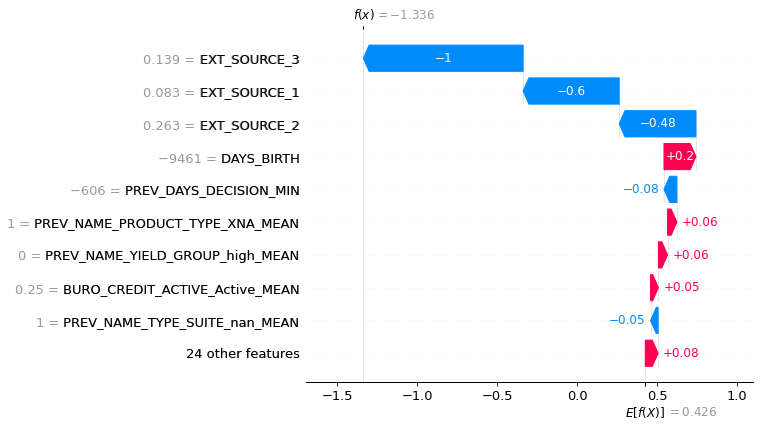

In [136]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [133]:
shap_values[0]

.values =
array([-4.15072564e-02,  1.99935762e-01, -1.67757456e-02, -1.18653174e-02,
       -7.31384218e-03, -6.00300103e-01, -4.79743928e-01, -9.98156650e-01,
        1.68401531e-02, -1.62501832e-02,  1.49098416e-02,  4.83188253e-03,
       -6.99775713e-03,  4.91902690e-02,  6.86625158e-04,  2.10356128e-02,
        3.88580051e-04, -8.85476594e-04, -1.46937633e-03,  2.16440304e-02,
        3.96390022e-03, -8.07523249e-02, -5.60878621e-03,  4.65415609e-02,
       -2.09879454e-02, -4.72658529e-02,  5.83042367e-02,  9.03364213e-03,
        5.72054596e-02,  4.31919370e-02,  9.40349876e-03,  1.48228692e-02,
        2.41749101e-03])

.base_values =
0.42599687672257336

.data =
array([-0.14825975,  1.50513841,  0.37753169,  0.57599029, -0.63237422,
       -3.02320594, -1.31759668, -2.15485127, -0.20784553,  0.41679415,
        0.71594554,  0.39164932, -1.27443202, -0.55110739,  1.11338449,
       -0.2526708 , -0.25356402,  0.66477161,  0.10793182,  0.68974544,
        0.77810509,  1.10640988,

In [134]:
shap_values.data = X.values

In [135]:
shap_values

.values =
array([[-4.15072564e-02,  1.99935762e-01, -1.67757456e-02,
        -1.18653174e-02, -7.31384218e-03, -6.00300103e-01,
        -4.79743928e-01, -9.98156650e-01,  1.68401531e-02,
        -1.62501832e-02,  1.49098416e-02,  4.83188253e-03,
        -6.99775713e-03,  4.91902690e-02,  6.86625158e-04,
         2.10356128e-02,  3.88580051e-04, -8.85476594e-04,
        -1.46937633e-03,  2.16440304e-02,  3.96390022e-03,
        -8.07523249e-02, -5.60878621e-03,  4.65415609e-02,
        -2.09879454e-02, -4.72658529e-02,  5.83042367e-02,
         9.03364213e-03,  5.72054596e-02,  4.31919370e-02,
         9.40349876e-03,  1.48228692e-02,  2.41749101e-03]])

.base_values =
array([0.42599688])

.data =
array([[ 1.88010000e-02, -9.46100000e+03, -3.64800000e+03,
        -2.12000000e+03,  1.00000000e+01,  8.30369674e-02,
         2.62948593e-01,  1.39375780e-01, -1.13400000e+03,
        -1.43700000e+03, -1.03000000e+02, -8.74000000e+02,
         1.37500000e+01,  2.50000000e-01,  5.00000000e-01,

In [ ]:
var data = [
  {
    type: "indicator",
    mode: "number+gauge+delta",
    gauge: { shape: "bullet" },
    delta: { reference: 300 },
    value: 220,
    domain: { x: [0, 1], y: [0, 1] },
    title: { text: "Profit" }
  }
];

var layout = { width: 600, height: 250 };
Plotly.newPlot('myDiv', data, layout);